In [ ]:
## HYPOTHESIS B

!pip install torch torchvision --quiet

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split

import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:


from torchvision import transforms

# standard transform for Fashion-MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, random_split

# custom binary-label Fashion-MNIST dataset
class BinaryFashionMNIST(Dataset):
    def __init__(self, train=True, transform=None):
        self.data = datasets.FashionMNIST(
            root='./data',
            train=train,
            download=True,
            transform=transform
        )
        # tops classes: T-shirt/top(0), Pullover(2), Dress(3), Coat(4), Shirt(6)
        self.top_classes = {0, 2, 3, 4, 6}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        y_bin = 1 if y in self.top_classes else 0
        return x, y_bin

full_train = BinaryFashionMNIST(train=True, transform=transform)
test_set  = BinaryFashionMNIST(train=False, transform=transform)

train_size = int(0.9 * len(full_train))
val_size   = len(full_train) - train_size
train_set, val_set = random_split(full_train, [train_size, val_size])

batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False)

print("Train size:", len(train_set))
print("Val size:", len(val_set))
print("Test size:", len(test_set))

samples = [train_set[i][1] for i in range(1000)]
print("Sample label distribution (first 1000 train ex):",
      "tops:", sum(samples), "others:", len(samples) - sum(samples))


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 199kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.70MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.1MB/s]


Train size: 54000
Val size: 6000
Test size: 10000
Sample label distribution (first 1000 train ex): tops: 498 others: 502


In [ ]:
# model arch

import torch.nn as nn
import torch.nn.functional as F


class StrongCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(64 * 7 * 7, 128)
        self.fc2   = nn.Linear(128, 1)  # binary output (logit)

    def forward(self, x):
        # input: [batch, 1, 28, 28]
        x = self.pool(F.relu(self.conv1(x)))  # -> [batch, 32, 14, 14]
        x = self.pool(F.relu(self.conv2(x)))  # -> [batch, 64, 7, 7]
        x = x.view(x.size(0), -1)             # -> [batch, 64*7*7]
        x = F.relu(self.fc1(x))
        x = self.fc2(x).squeeze(1)            # -> [batch]
        return x  # logits

# shallow underfitted model
class ShallowNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)            # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x).squeeze(1)
        return x  # logits

print("StrongCNN and ShallowNet defined.")


StrongCNN and ShallowNet defined.


In [ ]:


import torch


def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device).float()

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)

    avg_loss = total_loss / len(loader.dataset)
    return avg_loss

# evaluation: loss + classification error
def eval_model(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).float()

            logits = model(x)
            loss = criterion(logits, y)
            total_loss += loss.item() * x.size(0)

            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()
            correct += (preds == y).sum().item()
            total += y.size(0)

    avg_loss = total_loss / total
    error = 1.0 - correct / total
    return avg_loss, error

# get soft labels (probabilities) on a dataset
def get_soft_labels(model, loader, device, T=None):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            if T is not None:
                logits = logits / T
            probs = torch.sigmoid(logits)  # pθ(y=1 | x)
            all_probs.append(probs.cpu())
            all_labels.append(y)

    return torch.cat(all_probs), torch.cat(all_labels)

# Bayes error estimator from probabilities
def bayes_error_from_probs(probs):
    # probs: tensor of shape [N], values in [0,1]
    return torch.min(probs, 1 - probs).mean().item()

print("Training, eval, soft-label, and Bayes-error helpers ready.")


Training, eval, soft-label, and Bayes-error helpers ready.


In [ ]:

criterion_logits = nn.BCEWithLogitsLoss()

overfit_model = StrongCNN().to(device)
optimizer_overfit = optim.Adam(overfit_model.parameters(), lr=1e-3)

num_epochs_overfit = 40

for epoch in range(num_epochs_overfit):
    train_loss = train_epoch(overfit_model, train_loader, optimizer_overfit, criterion_logits, device)
    val_loss, val_err = eval_model(overfit_model, val_loader, criterion_logits, device)
    print(f"[Overfit] Epoch {epoch+1:02d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_err={val_err:.4f}")


[Overfit] Epoch 01: train_loss=0.0576, val_loss=0.0275, val_err=0.0083
[Overfit] Epoch 02: train_loss=0.0261, val_loss=0.0363, val_err=0.0127
[Overfit] Epoch 03: train_loss=0.0185, val_loss=0.0216, val_err=0.0083
[Overfit] Epoch 04: train_loss=0.0136, val_loss=0.0182, val_err=0.0055
[Overfit] Epoch 05: train_loss=0.0110, val_loss=0.0156, val_err=0.0057
[Overfit] Epoch 06: train_loss=0.0090, val_loss=0.0152, val_err=0.0052
[Overfit] Epoch 07: train_loss=0.0061, val_loss=0.0213, val_err=0.0067
[Overfit] Epoch 08: train_loss=0.0061, val_loss=0.0152, val_err=0.0047
[Overfit] Epoch 09: train_loss=0.0042, val_loss=0.0174, val_err=0.0042
[Overfit] Epoch 10: train_loss=0.0034, val_loss=0.0174, val_err=0.0048
[Overfit] Epoch 11: train_loss=0.0030, val_loss=0.0170, val_err=0.0045
[Overfit] Epoch 12: train_loss=0.0027, val_loss=0.0197, val_err=0.0053
[Overfit] Epoch 13: train_loss=0.0027, val_loss=0.0248, val_err=0.0063
[Overfit] Epoch 14: train_loss=0.0025, val_loss=0.0352, val_err=0.0075
[Overf

In [ ]:
base_model = StrongCNN().to(device)
optimizer_base = optim.Adam(base_model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion_logits = nn.BCEWithLogitsLoss()

num_epochs_base = 15
best_val_err = 1.0
best_state = None

for epoch in range(num_epochs_base):
    train_loss = train_epoch(base_model, train_loader, optimizer_base, criterion_logits, device)
    val_loss, val_err = eval_model(base_model, val_loader, criterion_logits, device)
    print(f"[Base] Epoch {epoch+1:02d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_err={val_err:.4f}")


    if val_err < best_val_err:
        best_val_err = val_err
        best_state = base_model.state_dict()

if best_state is not None:
    base_model.load_state_dict(best_state)
    print(f"Loaded best base_model with val_err={best_val_err:.4f}")
else:
    print("Warning: best_state is None (this should not happen).")


[Base] Epoch 01: train_loss=0.0626, val_loss=0.0314, val_err=0.0108
[Base] Epoch 02: train_loss=0.0299, val_loss=0.0312, val_err=0.0103
[Base] Epoch 03: train_loss=0.0218, val_loss=0.0256, val_err=0.0087
[Base] Epoch 04: train_loss=0.0178, val_loss=0.0179, val_err=0.0057
[Base] Epoch 05: train_loss=0.0152, val_loss=0.0248, val_err=0.0077
[Base] Epoch 06: train_loss=0.0128, val_loss=0.0165, val_err=0.0052
[Base] Epoch 07: train_loss=0.0100, val_loss=0.0178, val_err=0.0057
[Base] Epoch 08: train_loss=0.0099, val_loss=0.0194, val_err=0.0072
[Base] Epoch 09: train_loss=0.0090, val_loss=0.0160, val_err=0.0055
[Base] Epoch 10: train_loss=0.0074, val_loss=0.0182, val_err=0.0053
[Base] Epoch 11: train_loss=0.0068, val_loss=0.0161, val_err=0.0057
[Base] Epoch 12: train_loss=0.0065, val_loss=0.0164, val_err=0.0050
[Base] Epoch 13: train_loss=0.0056, val_loss=0.0187, val_err=0.0050
[Base] Epoch 14: train_loss=0.0056, val_loss=0.0167, val_err=0.0042
[Base] Epoch 15: train_loss=0.0048, val_loss=0.0

In [ ]:


under_model = ShallowNet().to(device)
optimizer_under = optim.Adam(under_model.parameters(), lr=1e-3)
criterion_logits = nn.BCEWithLogitsLoss()

num_epochs_under = 5

for epoch in range(num_epochs_under):
    train_loss = train_epoch(under_model, train_loader, optimizer_under, criterion_logits, device)
    val_loss, val_err = eval_model(under_model, val_loader, criterion_logits, device)
    print(f"[Under] Epoch {epoch+1:02d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_err={val_err:.4f}")


[Under] Epoch 01: train_loss=0.0870, val_loss=0.0586, val_err=0.0172
[Under] Epoch 02: train_loss=0.0488, val_loss=0.0479, val_err=0.0130
[Under] Epoch 03: train_loss=0.0413, val_loss=0.0434, val_err=0.0138
[Under] Epoch 04: train_loss=0.0363, val_loss=0.0436, val_err=0.0123
[Under] Epoch 05: train_loss=0.0314, val_loss=0.0381, val_err=0.0120


In [ ]:

base_model.eval()
val_logits_list = []
val_labels_list = []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        logits = base_model(x)
        val_logits_list.append(logits)
        val_labels_list.append(y.to(device).float())

val_logits = torch.cat(val_logits_list)
val_labels = torch.cat(val_labels_list)

print("val_logits shape:", val_logits.shape)
print("val_labels shape:", val_labels.shape)

# optimize temperature T to minimize NLL on validation set
T = torch.ones(1, device=device, requires_grad=True)
bce = nn.BCEWithLogitsLoss()
optimizer_T = optim.LBFGS([T], lr=0.01, max_iter=1000, line_search_fn='strong_wolfe')

def eval_T():
    optimizer_T.zero_grad()
    scaled_logits = val_logits / T
    loss = bce(scaled_logits, val_labels)
    loss.backward()
    return loss

optimizer_T.step(eval_T)
print("Optimal temperature T* =", T.item())


val_logits shape: torch.Size([6000])
val_labels shape: torch.Size([6000])
Optimal temperature T* = 1.477621078491211


In [ ]:

def eval_model_with_T(model, loader, criterion, device, T=None):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).float()

            logits = model(x)
            if T is not None:
                logits = logits / T
            loss = criterion(logits, y)
            total_loss += loss.item() * x.size(0)

            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()
            correct += (preds == y).sum().item()
            total += y.size(0)

    avg_loss = total_loss / total
    error = 1.0 - correct / total
    return avg_loss, error

# 1) Overfitted model
probs_overfit, y_test = get_soft_labels(overfit_model, test_loader, device, T=None)
test_loss_over, test_err_over = eval_model(overfit_model, test_loader, criterion_logits, device)
beta_over = bayes_error_from_probs(probs_overfit)

# 2) Underfitted model
probs_under, _ = get_soft_labels(under_model, test_loader, device, T=None)
test_loss_under, test_err_under = eval_model(under_model, test_loader, criterion_logits, device)
beta_under = bayes_error_from_probs(probs_under)

# 3) Base model (uncalibrated & calibrated)
# uncalibrated
probs_base_raw, _ = get_soft_labels(base_model, test_loader, device, T=None)
test_loss_base_raw, test_err_base_raw = eval_model(base_model, test_loader, criterion_logits, device)
beta_base_raw = bayes_error_from_probs(probs_base_raw)

# calibrated (using T*)
T_star = T.item()
probs_base_calib, _ = get_soft_labels(base_model, test_loader, device, T=T_star)
test_loss_base_calib, test_err_base_calib = eval_model_with_T(base_model, test_loader, criterion_logits, device, T=T_star)
beta_base_calib = bayes_error_from_probs(probs_base_calib)

print("\n=== Test errors & Bayes-error estimates ===")
print(f"Overfitted model:   test_err = {test_err_over:.4f},  Bayes_est = {beta_over:.4f}")
print(f"Underfitted model:  test_err = {test_err_under:.4f},  Bayes_est = {beta_under:.4f}")
print(f"Base (raw):         test_err = {test_err_base_raw:.4f},  Bayes_est = {beta_base_raw:.4f}")
print(f"Base (calibrated):  test_err = {test_err_base_calib:.4f},  Bayes_est = {beta_base_calib:.4f}")



=== Test errors & Bayes-error estimates ===
Overfitted model:   test_err = 0.0053,  Bayes_est = 0.0009
Underfitted model:  test_err = 0.0130,  Bayes_est = 0.0100
Base (raw):         test_err = 0.0072,  Bayes_est = 0.0041
Base (calibrated):  test_err = 0.0072,  Bayes_est = 0.0074


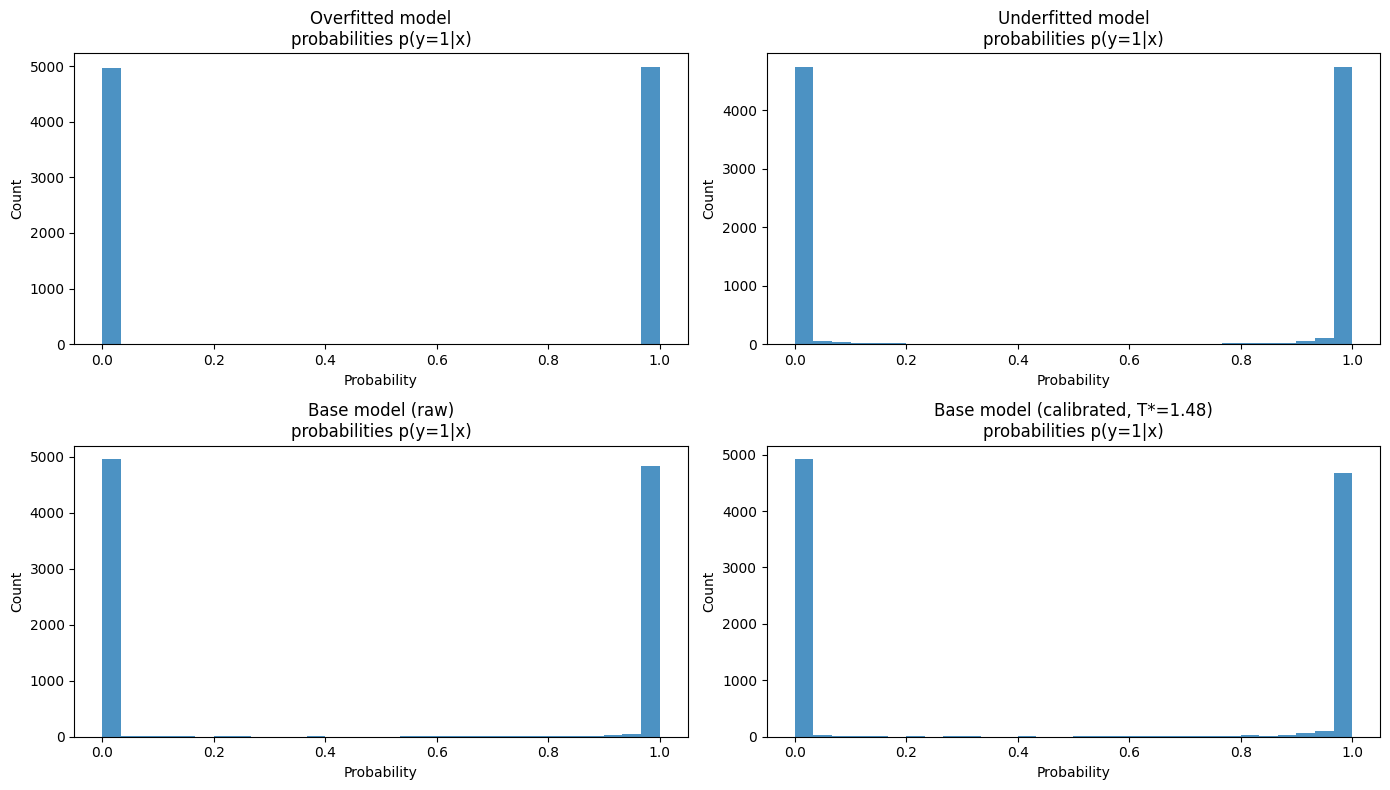

In [ ]:


import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

bins = 30

# Overfitted
plt.subplot(2, 2, 1)
plt.hist(probs_overfit.numpy(), bins=bins, range=(0, 1), alpha=0.8)
plt.title("Overfitted model\nprobabilities p(y=1|x)")
plt.xlabel("Probability")
plt.ylabel("Count")

# Underfitted
plt.subplot(2, 2, 2)
plt.hist(probs_under.numpy(), bins=bins, range=(0, 1), alpha=0.8)
plt.title("Underfitted model\nprobabilities p(y=1|x)")
plt.xlabel("Probability")
plt.ylabel("Count")

# Base raw
plt.subplot(2, 2, 3)
plt.hist(probs_base_raw.numpy(), bins=bins, range=(0, 1), alpha=0.8)
plt.title("Base model (raw)\nprobabilities p(y=1|x)")
plt.xlabel("Probability")
plt.ylabel("Count")

# Base calibrated
plt.subplot(2, 2, 4)
plt.hist(probs_base_calib.numpy(), bins=bins, range=(0, 1), alpha=0.8)
plt.title(f"Base model (calibrated, T*={T_star:.2f})\nprobabilities p(y=1|x)")
plt.xlabel("Probability")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


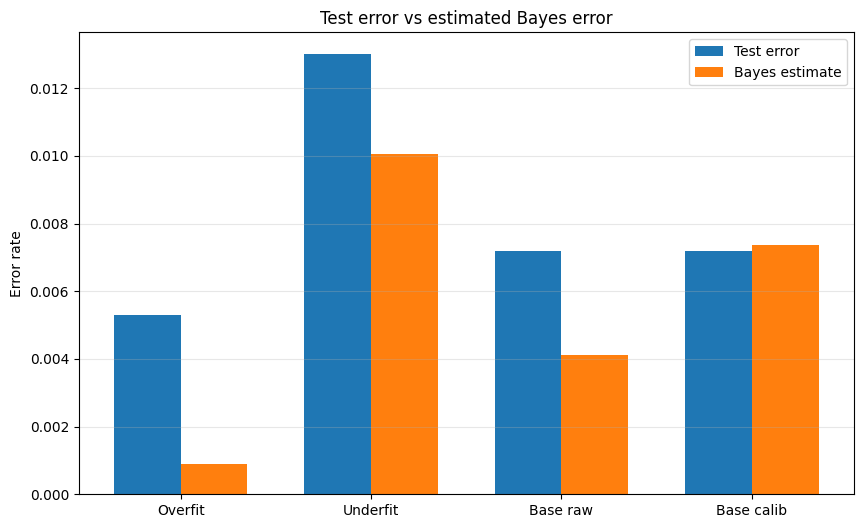

Overfit    -> test_err = 0.0053,  Bayes_est = 0.0009
Underfit   -> test_err = 0.0130,  Bayes_est = 0.0100
Base raw   -> test_err = 0.0072,  Bayes_est = 0.0041
Base calib -> test_err = 0.0072,  Bayes_est = 0.0074


In [ ]:


model_names = ["Overfit", "Underfit", "Base raw", "Base calib"]

test_errs = [
    test_err_over,
    test_err_under,
    test_err_base_raw,
    test_err_base_calib,
]

bayes_ests = [
    beta_over,
    beta_under,
    beta_base_raw,
    beta_base_calib,
]

x = np.arange(len(model_names))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, test_errs, width, label="Test error")
plt.bar(x + width/2, bayes_ests, width, label="Bayes estimate")

plt.xticks(x, model_names)
plt.ylabel("Error rate")
plt.title("Test error vs estimated Bayes error")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

for name, te, be in zip(model_names, test_errs, bayes_ests):
    print(f"{name:10s} -> test_err = {te:.4f},  Bayes_est = {be:.4f}")
